# Read in the data from Charles El Mir and output to "raw"

*The data are from [this article](https://www.sciencedirect.com/science/article/pii/S001910351830349X?via%3Dihub).*

*I will have to downsample considerably...*


In [43]:
%matplotlib notebook

import pandas as pd
import numpy as np
import os
import csv

from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from ipywidgets import *

### Get the total number of objects in all files

*The number of particles decreases as the time increases, but it's always around 1M.  We want about 1M objects total.  So the fraction that we will use in each file is about 1/Nfiles.*

In [77]:
fs = os.listdir()
files = []
nfiles = 0
for f in fs:
    if ('csv' in f):
        files.append(f)
#print(files)
nfiles = len(files)
frac = 1./nfiles #* 0.1 #to speed up everything for testing
print(frac)        


0.010752688172043012


### Grab a list of IDs from the first file

In [78]:
f = 'grav.000000000.csv'
df = pd.read_csv(f, header=None, names=['ID','x','y','z','color','damage'])
time = float(f[5:14])
df['time'] = time
dfSample = df.sample(frac=frac)
print(dfSample.shape)
print(dfSample)

(10934, 7)
              ID             x             y             z  color    damage  \
686113  686113.0    500.000533   5300.005647   2100.002238    2.0  0.175683   
224367  224367.0  -9900.010548   4700.005008  -3500.003729    3.0  0.126597   
442650  442650.0  -3100.003303   3100.003303  -8900.009483    5.0  0.153334   
133676  133676.0 -10100.010761   3900.004155   -900.000959    5.0  0.152145   
175363  175363.0  -6900.007352   1700.001811   4700.005008    3.0  0.128517   
695627  695627.0   3700.003942   4300.004582   3500.003729    3.0  0.130869   
793680  793680.0   8500.009057  -7300.007778   3700.003942    3.0  0.128809   
473042  473042.0  -1700.001811  -3300.003516  -4900.005221    3.0  0.131528   
656053  656053.0   -300.000320   9100.009696  -2500.002664    2.0  0.200000   
618177  618177.0  -3100.003303   5500.005860  -8500.009057    2.0  0.184962   
855565  855565.0   8300.008843  -1300.001385  -2900.003090    5.0  0.151907   
642667  642667.0  -1100.001172  11500.012

### Read through all the files, and only keep the rows that match these IDs

In [79]:
dfOut = dfSample.copy()
for i,f in enumerate(files):
    if (i > 0):
        df = pd.read_csv(f, header=None, names=['ID','x','y','z','color','damage'])
        time = float(f[5:14])
        df['time'] = time
        dfUse = df.loc[df['ID'].isin(dfSample['ID'].values)] 
        dfOut = dfOut.append(dfUse, ignore_index=True)
        print(f, dfOut.shape, dfUse.shape)

grav.000001000.csv (21857, 7) (10923, 7)
grav.000002000.csv (32768, 7) (10911, 7)
grav.000003000.csv (43663, 7) (10895, 7)
grav.000004000.csv (54542, 7) (10879, 7)
grav.000005000.csv (65398, 7) (10856, 7)


KeyboardInterrupt: 

## Write to "raw" file

*This is extremely slow because I want to match the IDs*

In [75]:
csvfile = open("asteroid.raw", 'wt')
csvwriter = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
for i in range(len(dfOut['ID'])):
    ID = dfOut['ID'].values[i]
    sameID = dfOut.loc[(dfOut['ID'] == ID) & (dfOut.index > i)]
    r,c = sameID.shape
    if (r == 0):
        sameID = dfOut.iloc[i].copy()
        sameID = sameID.append(dfOut.iloc[i].copy()) #so that I get a list of values
        
    csvwriter.writerow([dfOut['x'].values[i],dfOut['y'].values[i],dfOut['z'].values[i], 
                        sameID['x'].values[0],sameID['y'].values[0],sameID['z'].values[0],
                        dfOut['time'].values[i], dfOut['damage'].values[i], dfOut['ID'].values[i]])
csvfile.close()

## Plot the files

<IPython.core.display.Javascript object>


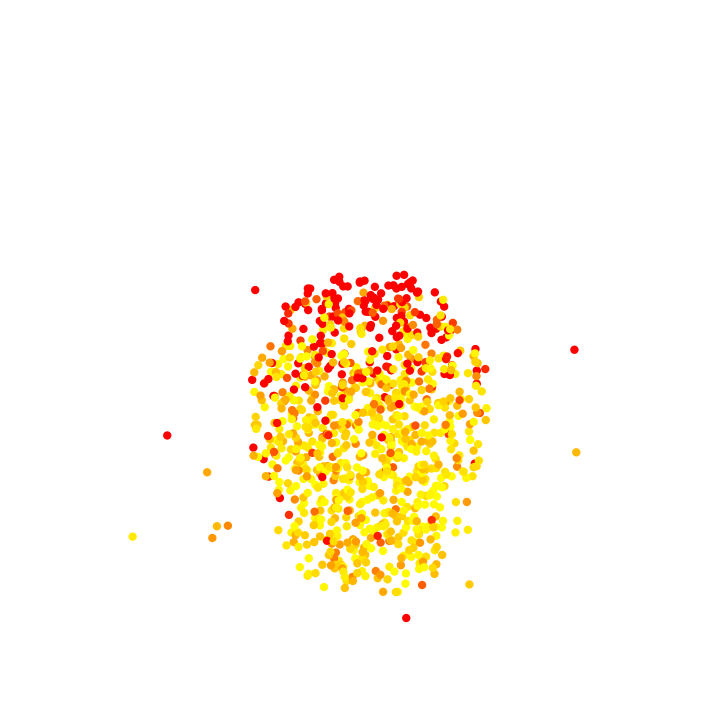

interactive(children=(FloatSlider(value=0.0, description='t', max=92000.0), Output()), _dom_classes=('widget-i…

<function __main__.update_plot(t=0)>

In [76]:
df = pd.read_csv('asteroid.raw', delimiter=' ', header=None, names=['x1','y1','z1','x2','y2','z2','time','damage','id'])
times = np.sort(np.array(list(set(df['time'].values))))
dt = np.diff(times)[0]
#print(times)
#print(dt)

dfUse = df.loc[df['time'].values == times[0]]

fig,ax = plt.subplots(figsize=(5,5))
scat = ax.scatter(dfUse['x1'].values, dfUse['y1'].values, s=10, 
                c=dfUse['damage'].values, cmap='autumn_r', vmin=0.125, vmax = 0.2)
ax.set_xlim(-20000, 20000)
ax.set_ylim(-25000, 20000)
ax.set_aspect('equal')
plt.axis('off')


def update_plot(t=0):
    
    tFrac = (t % dt)/dt
    dfUse = df.loc[(df['time'].values >= t) & (df['time'].values < t+dt)]
    x = dfUse['x1'].values + (dfUse['x2'].values - dfUse['x1'].values)*tFrac
    y = dfUse['y1'].values + (dfUse['y2'].values - dfUse['y1'].values)*tFrac
    # Change the colors.
    scat.set_array(dfUse['damage'].values)
    # Change the x,y positions. This expects a _single_ 2xN, 2D array
    scat.set_offsets(np.c_[x,y])
    #fig.canvas.draw()
    return scat,

interact(update_plot, t = widgets.FloatSlider(value=0, min=min(times),max=max(times),step=0.1))



0.12500004167900003 0.2


<IPython.core.display.Javascript object>


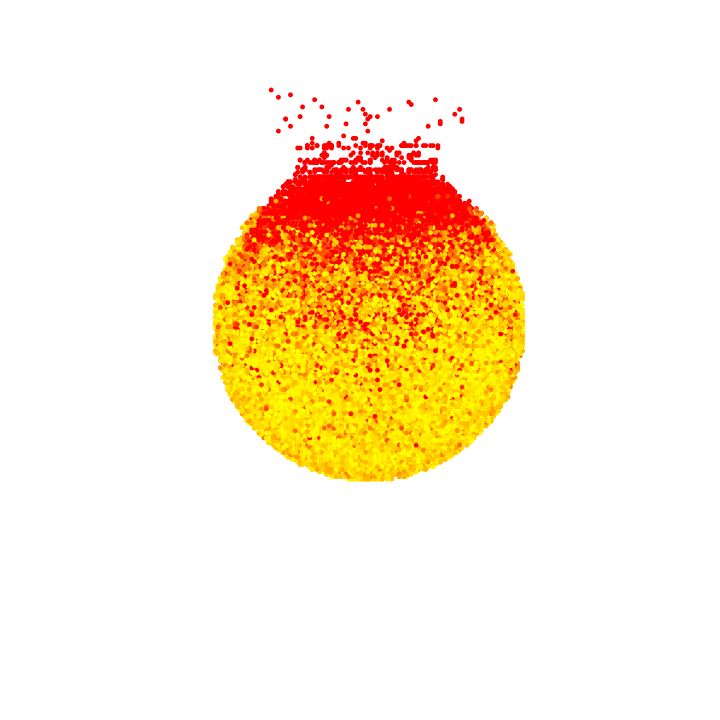

(-20000.0, 20000.0, -25000.0, 20000.0)

In [57]:
i=0
f = files[i]
#f = 'grav.000000000.csv'
#f = 'grav.000092000.csv'
df = pd.read_csv(f, header=None, names=['ID','x','y','z','color','damage'])
dfUse = df.sample(frac = 0.1)
print(min(dfUse['damage'].values), max(dfUse['damage'].values))
fig,ax = plt.subplots(figsize=(5,5))
scat = ax.scatter(dfUse['x'].values, dfUse['y'].values, s=2, 
                  c=dfUse['damage'].values, cmap='autumn_r', vmin=0.125, vmax = 0.2)
ax.set_xlim(-20000, 20000)
ax.set_ylim(-25000, 20000)
ax.set_aspect('equal')
ax.axis('off')